In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import codecs
import array
import sys
import os
from loadTDMS import *
import time

# import holoviews as hv
# from holoviews import opts
# hv.extension('bokeh')

In [2]:
def FFT_main(t, x, dt, split_t_r, overlap, window_F, output_FN, y_label, y_unit):

    # データをオーバーラップして分割する。
    split_data = data_split(t, x, split_t_r, overlap)

    # FFTを行う.
    FFT_result_list = []
    for split_data_cont in split_data:
        FFT_result_cont = FFT(split_data_cont, dt, window_F)
        FFT_result_list.append(FFT_result_cont)

    # 平均化
    fq_ave = FFT_result_list[0][0]
    F_abs_amp_ave = np.zeros(len(fq_ave))
    for i in range(len(FFT_result_list)):
        F_abs_amp_ave = F_abs_amp_ave + FFT_result_list[i][1]
    F_abs_amp_ave = F_abs_amp_ave/(i+1)

#     plot_FFT(t, x, fq_ave, F_abs_amp_ave, output_FN, "ave", 1, y_label, y_unit)

    return fq_ave, F_abs_amp_ave

In [3]:
def FFT(data_input, dt, window_F):

    N = len(data_input[0])

    # 窓の用意
    if window_F == "hanning":
        window = np.hanning(N)          # ハニング窓
    elif window_F == "hamming":
        window = np.hamming(N)          # ハミング窓
    elif window_F == "blackman":
        window = np.blackman(N)         # ブラックマン窓
    else:
        print("Error: input window function name is not sapported. Your input: ", window_F)
        print("Hanning window function is used.")
        hanning = np.hanning(N)          # ハニング窓

    # 窓関数後の信号
    x_windowed = data_input[1]*window

    # FFT計算
    F = np.fft.fft(x_windowed)
    F_abs = np.abs(F)
    F_abs_amp = F_abs / N * 2
    fq = np.linspace(0, 1.0/dt, N)
#     fq = np.linspace(0, N*dt, N)

    # 窓補正
    acf = 1/(sum(window)/N)
    F_abs_amp = acf*F_abs_amp

    # ナイキスト定数まで抽出
    fq_out = fq[:int(N/2)+1]
    F_abs_amp_out = F_abs_amp[:int(N/2)+1]

    return [fq_out, F_abs_amp_out]

In [4]:
def data_split(t, x, split_t_r, overlap):

    split_data = []
    one_frame_N = int(len(t)*split_t_r)  # 1フレームのサンプル数
    overlap_N = int(one_frame_N*overlap)  # オーバーラップするサンプル数
    start_S = 0
    end_S = start_S + one_frame_N

    while True:
        t_cont = t[start_S:end_S]
        x_cont = x[start_S:end_S]
        split_data.append([t_cont, x_cont])

        start_S = start_S + (one_frame_N - overlap_N)
        end_S = start_S + one_frame_N

        if end_S > len(t):
            break

    return np.array(split_data)

In [5]:
def plot_FFT(t, x, fq, F_abs_amp, output_FN, IDN, final_graph, y_label, y_unit):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.xlabel('freqency(kHz)', fontsize=16)

    plt.ylabel(y_label+"[dB]", fontsize=16)

    ax.set_xlim(0,500000)
    ax.set_xticklabels([ 0 ,100, 200, 300, 400, 500])

    plt.plot(fq, 20 * np.log10(F_abs_amp))

    p = plt.tick_params(labelsize=16)
    plt.tight_layout()

    if final_graph == 0:
        plt.savefig(output_FN[:-4]+"_"+str(IDN) +
                    "_FFTtemp"+output_FN[-4:], dpi=300)
    elif final_graph == 1:
        plt.savefig(output_FN, dpi=300)
    return 0

In [7]:
ae_rms = []
start = time.time()
num = 0
cutting_distance = []
output_FN_rms = f"./AE_IFFT/rms.png"
final_graph = 1
IDN = "ave"

for i in range(24,502):
    path_num = i
    data_num = 24 + 2*(path_num-1)
    path = rf'Z:\100 実験データ（RAW）\20211115---切削実験---AE+切削抵抗\AE\1-5000\AE_{data_num}.tdms'
    d = load_tdms(path, ch_num=3)

    # 1サンプリングするのにかかる時間
    dt = 1/10**6
    last_t = 0
    print(i,len(d[0]))
    if i == 1:
        y = d[0][0:16285]
    else:
#         y=d[0][5000000:5000000+512]
        y = d[0][5000000:5016385]
#         y = d[0][5000000:5000000+32768]
#         y = d[0][5000000:5000000+65536]
#         y = d[0][5000000:5000000+131072]
#         y = d[0][5000000:5000000+262144]
#         y = d[0][5000000:5000000+524288]
    N = len(y)
    f = y
#     fq = np.linspace(0, N*dt, N)  # 周波数軸　linspace(開始,終了,分割数)

#     output_FN = f"./AE_IFFT/FFT_{data_num}.png"
#     split_t_r = 0.1  # 1つの枠で全体のどの割合のデータを分析するか。
#     overlap = 0.5  # オーバーラップ率
#     window_F = "hanning"  # 窓関数選択: hanning, hamming, blackman
#     y_label = "amplitude"
#     y_unit = "V"

#     abcd = FFT_main(fq, f, dt, split_t_r, overlap, window_F, output_FN, y_label, y_unit)
    
    freq = np.fft.fftfreq(N, d =dt)
    F = np.fft.fft(y)
    F2 = np.copy(F)
    ind = (freq<300000) & (freq>-300000)
    F2[ind] = 0
    Z2 = np.fft.ifft(F2)
    avg = np.average(np.abs(Z2.real))
#     plt.plot(Z.real)
    ae_rms.append(avg)
    cutting_distance.append(num*49/1000)
    
    print(cutting_distance[num], ae_rms[num])
    num = num+1

    
ae_rms_m = [n*10000 for n in ae_rms]

fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('cutting distance [m]', fontsize=16)

plt.ylabel("AE RMS ×$10^-4$ [V]", fontsize=16)

# ax.set_xlim(0,500000)
# ax.set_xticklabels([0, 2, 4, 6, 8, 11])

plt.plot(cutting_distance, ae_rms_m)

p = plt.tick_params(labelsize=16)
plt.tight_layout()

if final_graph == 0:
    plt.savefig(output_FN_rms[:-4]+"_"+str(IDN) +
                "_FFTtemp"+output_FN_rms[-4:], dpi=300)
elif final_graph == 1:
    plt.savefig(output_FN, dpi=300)

# print(ae_rms)
# plt.plot(ae_rms)

end = time.time()
print(end - start)

24 15613420
0.0 0.0003843461686815762
25 15610254
0.049 0.00038395077948658317
26 15622646
0.098 0.00038215399395366204
27 15631908
0.147 0.000373081838310015
28 15641171
0.196 0.0003568536852268479
29 15632477
0.245 0.0003744580070878395
30 15637412
0.294 0.0003903214672746934
31 15616925
0.343 0.00037892266037904405
32 15602872
0.392 0.00037034143103263336
33 15638633
0.441 0.00036982433888836506
34 15631031
0.49 0.00037087970653845996
35 15643367
0.539 0.0003511427509984
36 15638968
0.588 0.00038302833591221665
37 15620762
0.637 0.0003776433620695361
38 15637198
0.686 0.0003597143264177124
39 15634476
0.735 0.00037000273385702574
40 15645665
0.784 0.0003473267635393532
41 15650124
0.833 0.0003429944331469942
42 15629649
0.882 0.0003470620016255135
43 15643488
0.931 0.00036500223264338114
44 15651635
0.98 0.0003532683543480672
45 15617914
1.029 0.00034782339854561636
46 15648190
1.078 0.0003439247179748327
47 15615748
1.127 0.00035284659494192545
48 15652460
1.176 0.00035160140049867

225 15629970
9.849 0.0002713508921998876
226 15627803
9.898 0.00024877367422948
227 15623775
9.947 0.00026025889368840087
228 15630847
9.996 0.00026372438729296214
229 15634788
10.045 0.0002603442132672308
230 15632131
10.094 0.0002498729038154979
231 15632355
10.143 0.0002492486112613309
232 15632333
10.192 0.00027076255001464854
233 15630510
10.241 0.0002515582161852489
234 15632490
10.29 0.00025977211477077244
235 15629955
10.339 0.00026253380900368665
236 15631199
10.388 0.0002721211176448949
237 15632219
10.437 0.0002496637448220924
238 15633584
10.486 0.00024808249782660465
239 15636131
10.535 0.0002596754896313846
240 15637257
10.584 0.0002563463840414524
241 15633961
10.633 0.00027325158937875843


FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\100 実験データ（RAW）\\20211115---切削実験---AE+切削抵抗\\AE\\1-5000\\AE_506.tdms'

NameError: name 'output_FN' is not defined

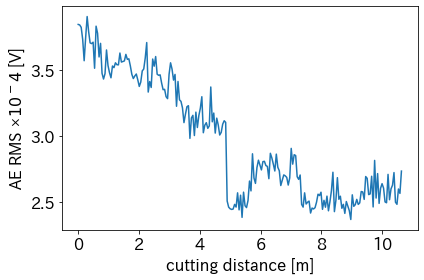

In [9]:
ae_rms_m = [n*10000 for n in ae_rms]

fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('cutting distance [m]', fontsize=16)

plt.ylabel("AE RMS ×$10^-4$ [V]", fontsize=16)

# ax.set_xlim(0,500000)
# ax.set_xticklabels([0, 2, 4, 6, 8, 11])

plt.plot(cutting_distance, ae_rms_m)

p = plt.tick_params(labelsize=16)
plt.tight_layout()

if final_graph == 0:
    plt.savefig(output_FN_rms[:-4]+"_"+str(IDN) +
                "_FFTtemp"+output_FN_rms[-4:], dpi=300)
elif final_graph == 1:
    plt.savefig(output_FN, dpi=300)

In [102]:
len(abcd[1])

820

In [105]:
haha = np.copy(abcd)
low_amp = np.where(haha[0]<300000)
# low_amp = np.where(haha[0]<0.1)
for low in low_amp:
    haha[1][low] = 0

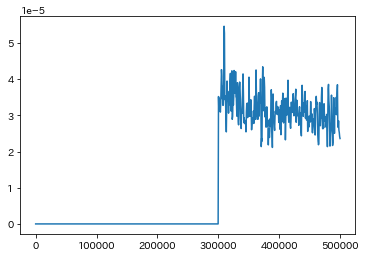

In [106]:
plt.plot(haha[0], haha[1])

In [ ]:
np.fft.ifft()

16385


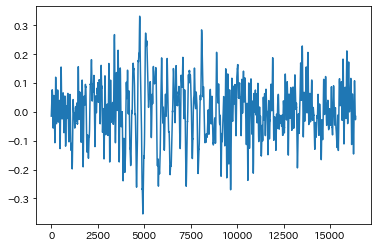

In [107]:
dx = 1/10**6
N = len(y)
print(N)
plt.plot(y)

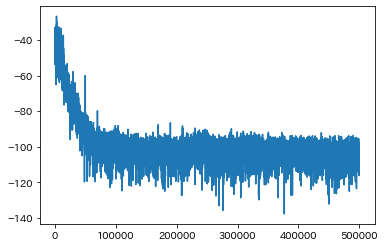

In [108]:
freq = np.fft.fftfreq(N, d =dx)
F = np.fft.fft(y)
plt.plot(freq[1:int(len(F)/2)], 20 * np.log10(np.abs(F/N*2)[1:int(len(F)/2)]))

In [109]:
F2 = np.copy(F)
ind = (freq<300000) & (freq>-300000)
# F2[ind] = 0.001
F2[ind] = 0
Z2 = np.fft.ifft(F2)
# print(len(F2))
# print(F2[100:500])
# plt.plot(freq[1:int(len(F2)/2)], 20 * np.log10(np.abs(F2/N*2)[1:int(len(F2)/2)]))

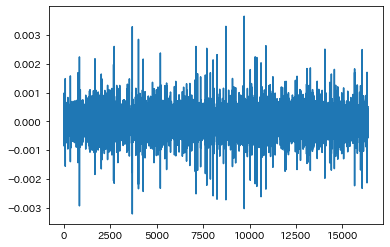

In [110]:
plt.plot(Z2.real)

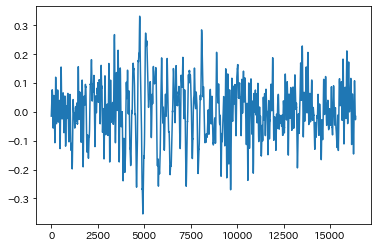

In [111]:
plt.plot(y)

In [15]:
F3 = np.copy(F)
ind = (freq>300000) & (freq<-300000)
# F2[ind] = 0.001
F3[ind] = 0
Z3 = np.fft.ifft(F3)
# print(len(F2))
# print(F2[100:500])
# plt.plot(freq[1:int(len(F2)/2)], 20 * np.log10(np.abs(F2/N*2)[1:int(len(F2)/2)]))
print(np.average(Z3.real))

0.0009341015552361275


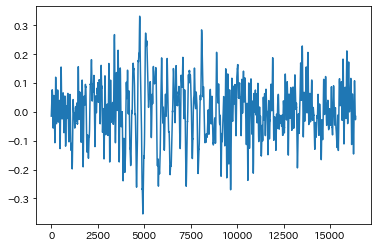

In [113]:
plt.plot(y)

In [23]:
mylist = [1,2,3,4,5,6,7,8,9]
newlist = [n*2 for n in mylist]
newlist

[2, 4, 6, 8, 10, 12, 14, 16, 18]